# EX6. 나의 첫 번째 캐글 경진대회, 무작정 따라해보기

### 캐글 코리아와 함께하는 2nd ML 대회 - House Price Prediction
집 값 예측은, 미국 아이오와 주의 에임스에 있는 주거용 주택의 정보를 이용하여 주택의 판매가격을 예측하는 Competition

[Data Description]
-----------------------------------------------------------------------------
### < File descriptions >
* train.csv - 예측 모델을 만들기 위해 사용하는 학습 데이터입니다. 집의 정보와 예측할 변수인 가격(Price) 변수를 가지고 있습니다.    

* test.csv - 학습셋으로 만든 모델을 가지고 예측할 가격(Price) 변수를 제외한 집의 정보가 담긴 테스트 데이터 입니다.    

* sample_submission.csv - 제출시 사용할 수 있는 예시 submission.csv 파일입니다.   


### < Data fields >   
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 집의 가격(Target variable)
4. bedrooms : 침실의 수
5. bathrooms : 화장실의 수
6. sqft_living : 주거 공간의 평방 피트(면적)
7. sqft_lot : 부지의 평방 피트(면적)
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트(면적)
14. sqft_basement : 지하실의 평방 피트(면적)
15. yr_built : 지어진 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

## 필요한 라이브러리 import하기

In [1]:
#시각화 그래프가 나타날 수 있도록 import
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
#LMS에서 사용할 때 알맞은 파일 경로 설정
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [4]:
# 데이터 불러오기
# 데이터를 data, sub이라는 변수로 불러옴
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [5]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 학습 데이터에서 라벨 제거하기
테스트 데이터는 우리가 맞추어야 할 집의 가격, price가 없기 때문에 컬럼이 하나 적기 때문에

In [7]:
#타겟데이터인 price는 따로 y에 저장하고 train데이터에서는 빼주기
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### 학습 데이터와 테스트 데이터 합치기

In [5]:
train_len = len(data) #모델 학습을 진행할 때에는 다시 분리해서 사용해야 하기 때문에 개수 저장
data = pd.concat((data, sub), axis=0) # 전체 데이터에 대해 탐색해보기 위해 concat으로 합침

print(len(data))

21503


<AxesSubplot:>

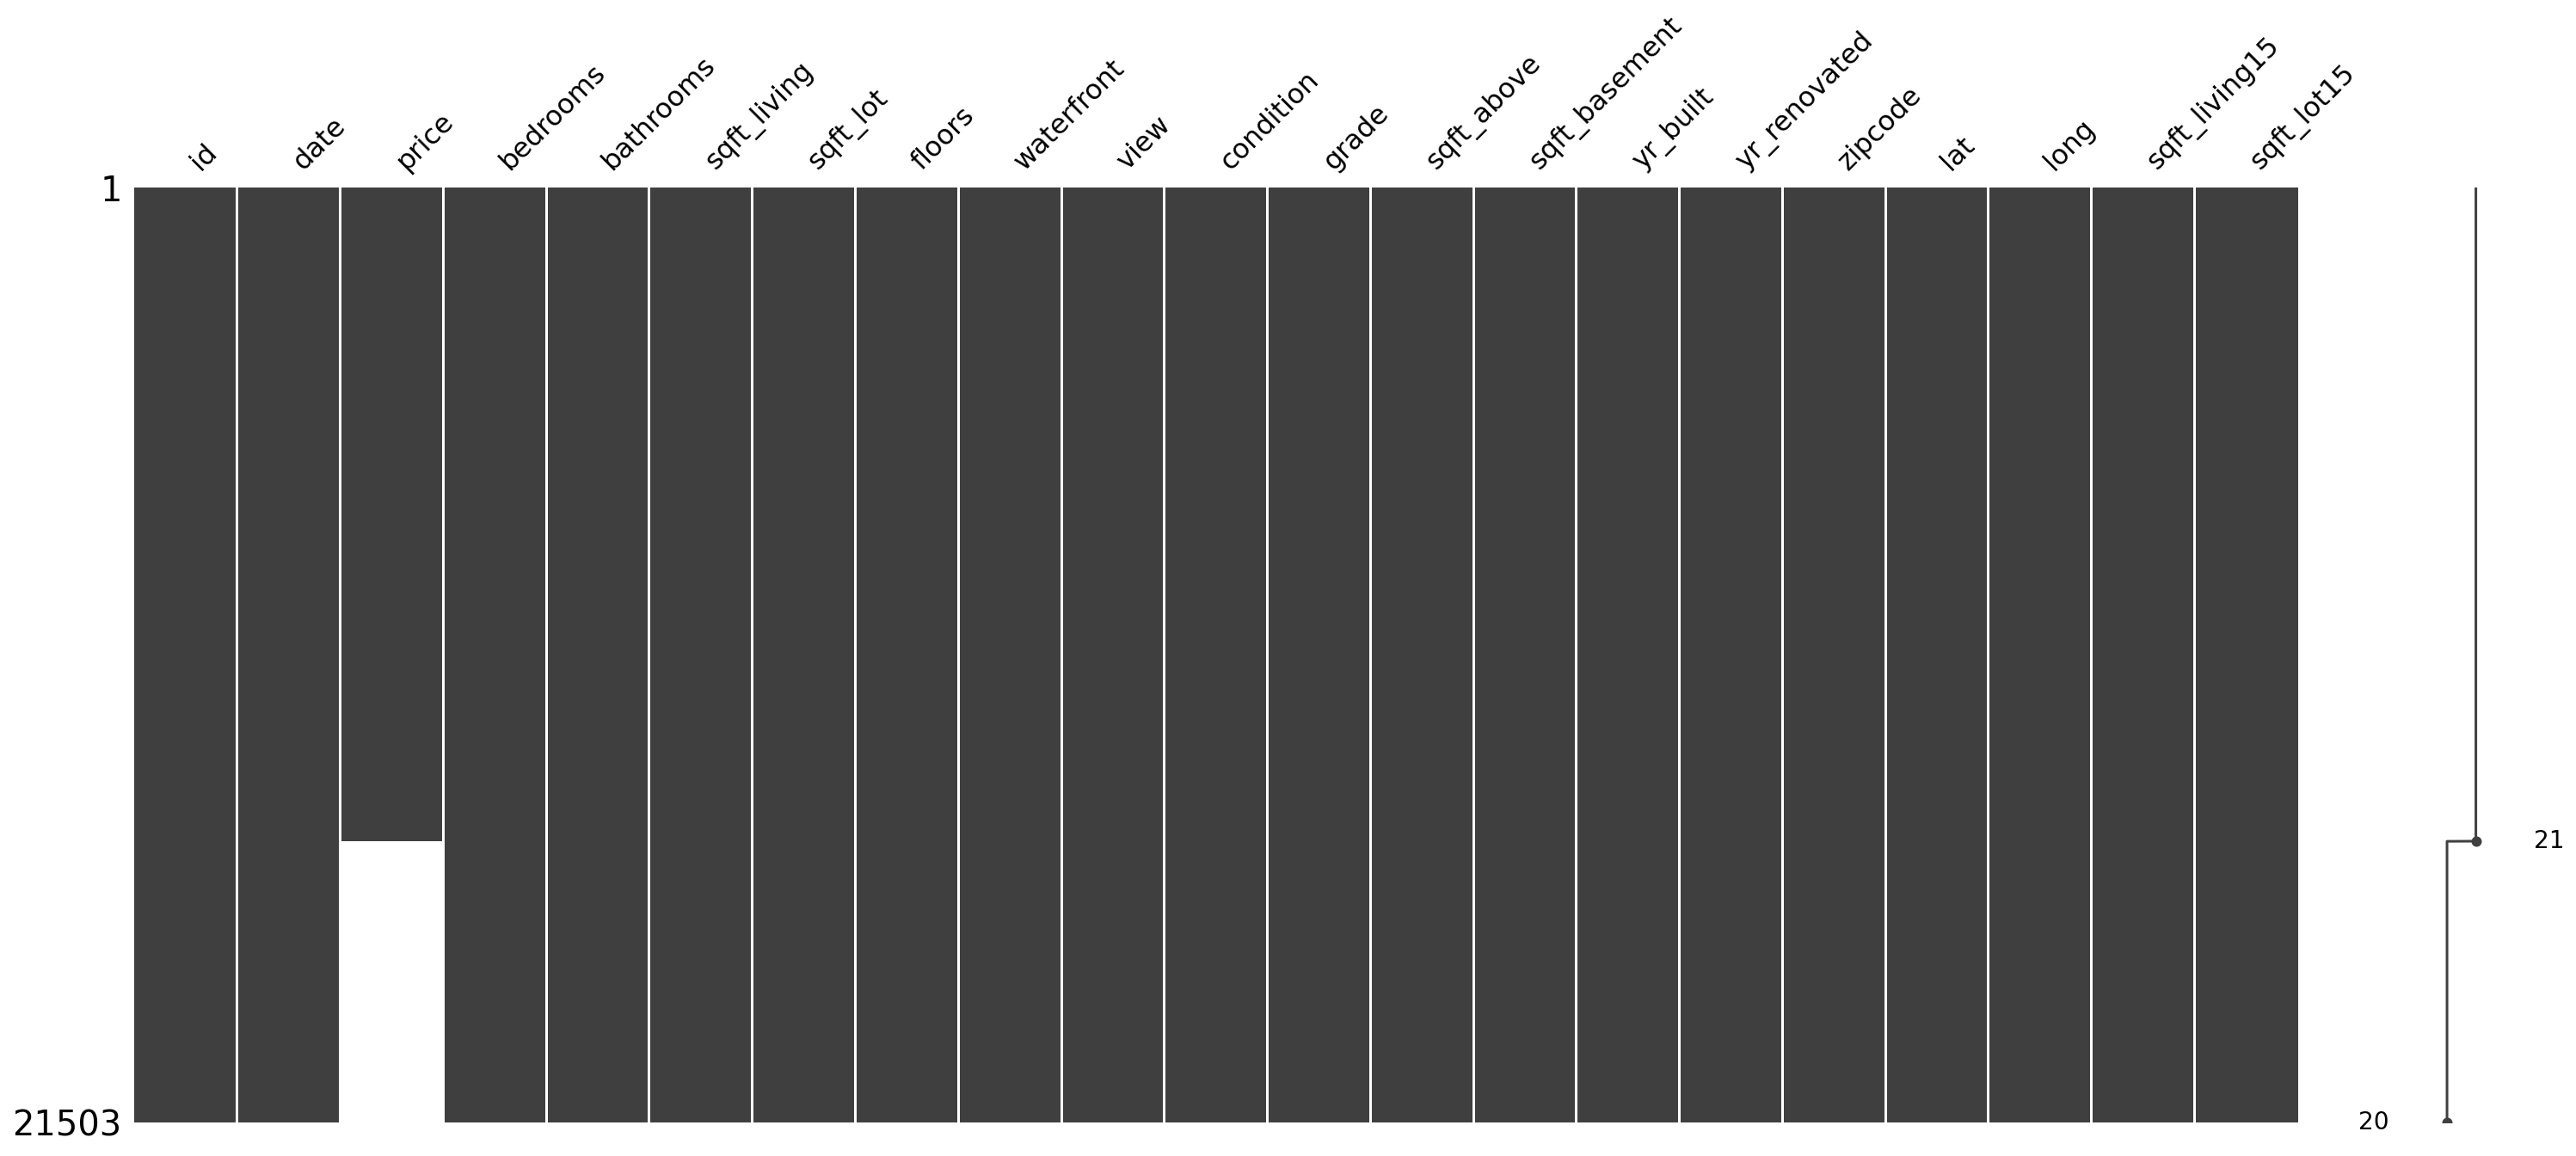

In [6]:
msno.matrix(data)

### 간단한 전처리    
* 빈 데이터와 전체 데이터의 분포를 확인하는 전처리 작업     
* missingno 라이브러리를 사용해서 확인

<AxesSubplot:>

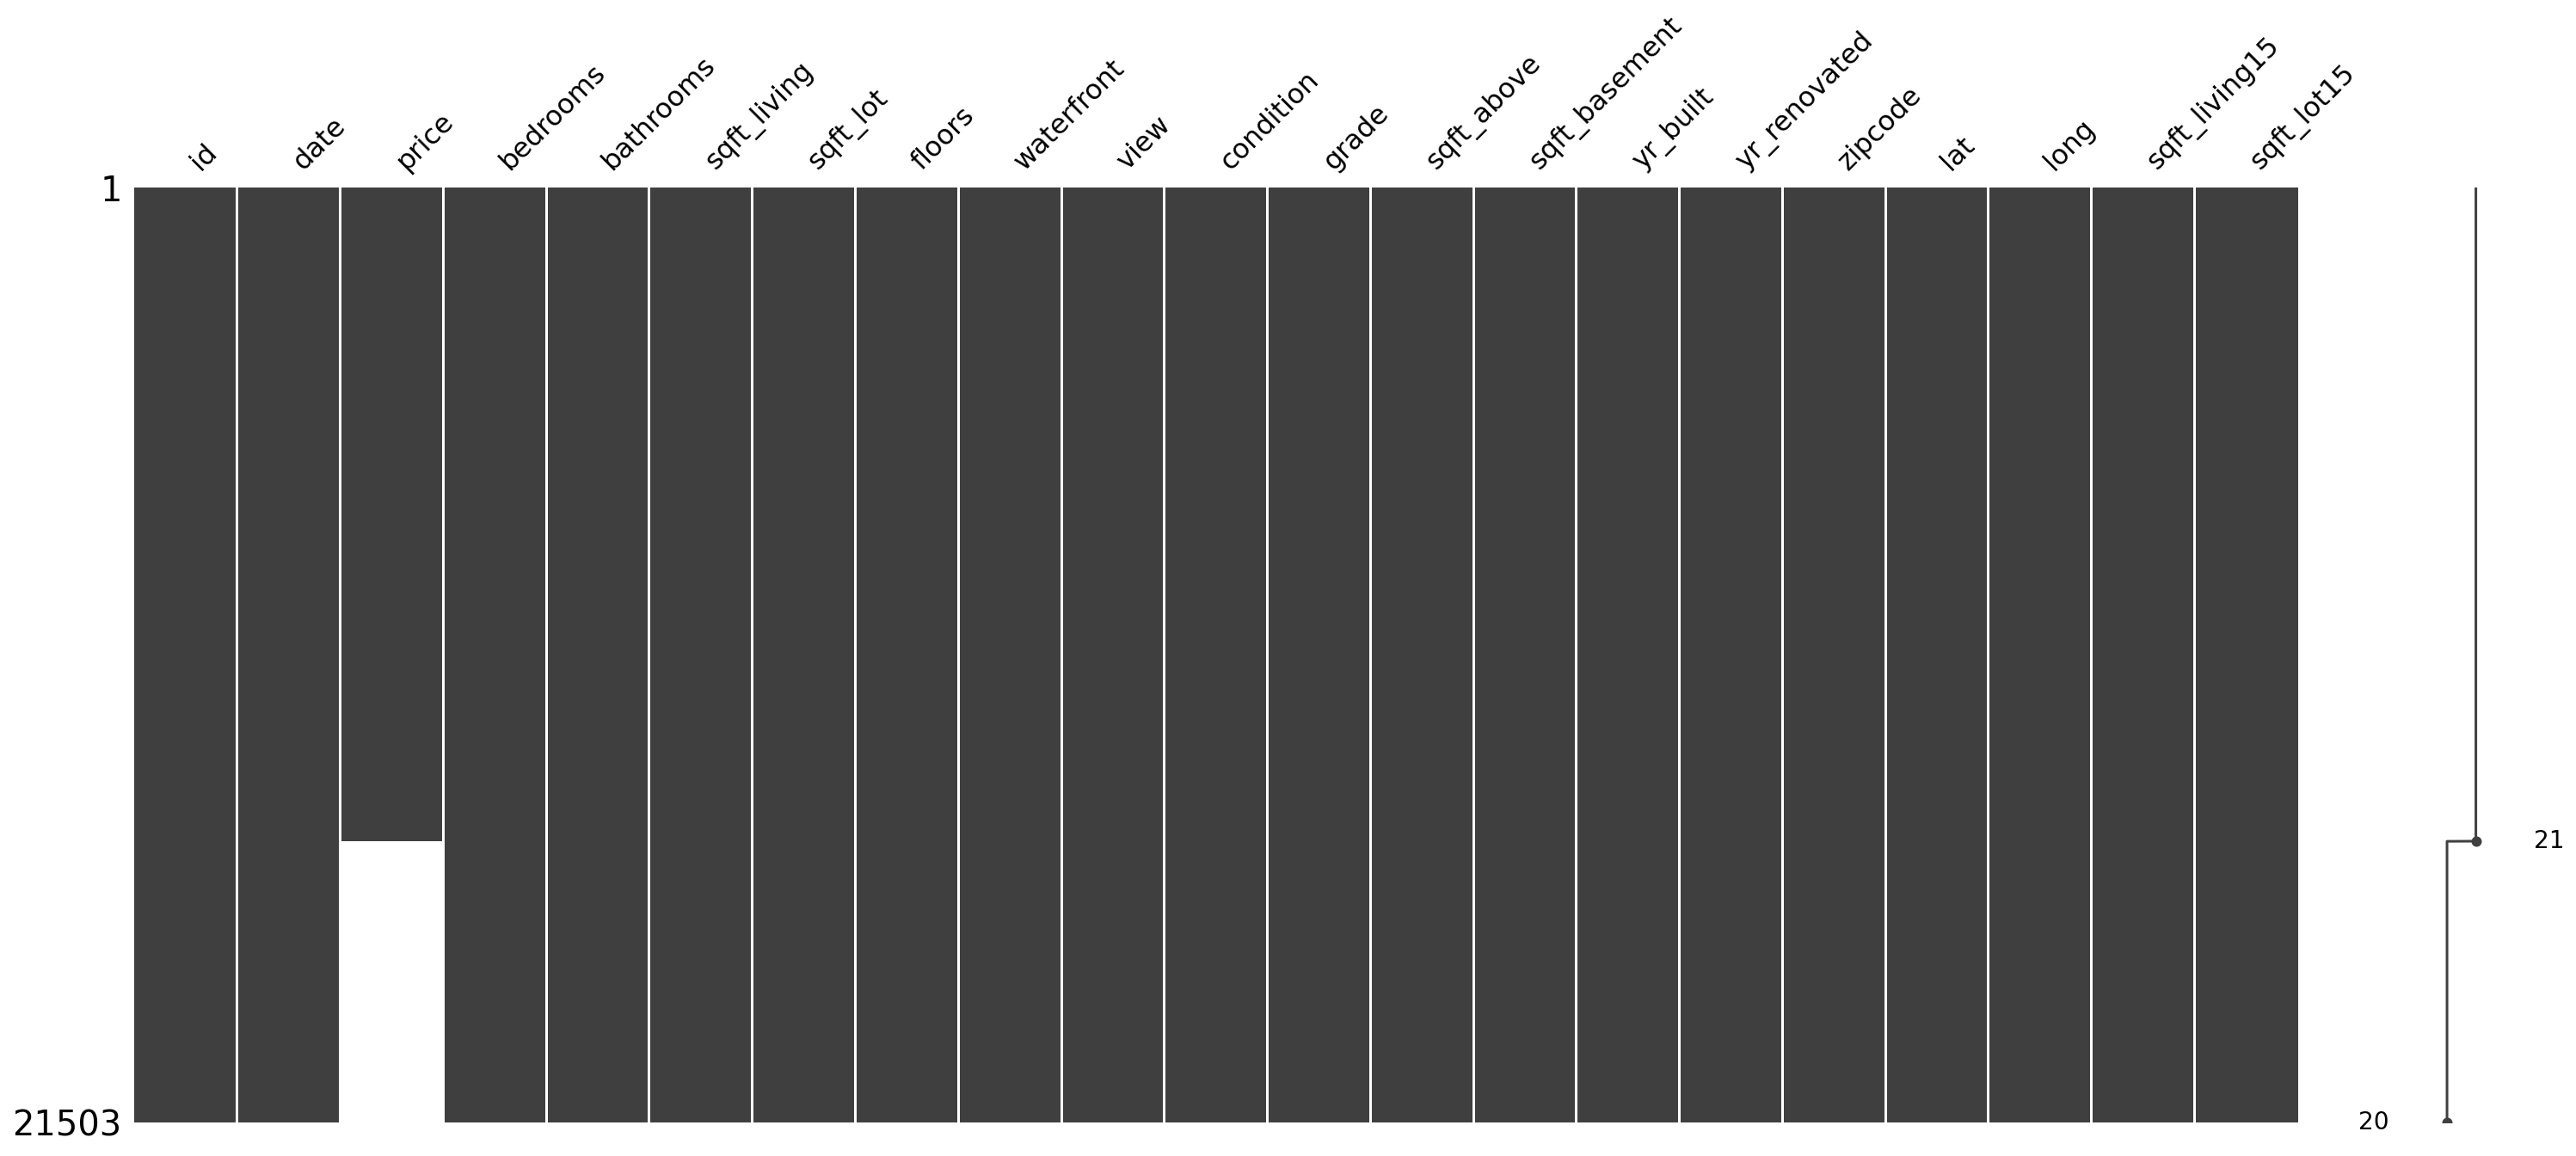

In [7]:
msno.matrix(data)

In [8]:
# 결측치의 개수를 출력
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
price : 6468
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리

In [9]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [10]:
# 여기에서 str(x[:6]) 으로 처리한 것은 20141013T000000 형식의 데이터를 연/월 데이터만 사용하기 위해 201410까지 자르기 위한 것
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 각 변수들의 분포 확인    
* 전체 데이터들의 분포를 확인     
* 너무 치우친 분포를 가지는 컬럼의 경우 모델이 결과를 예측하는 데에 좋지 않은 영향을 미치므로 다듬는 작업해주기   

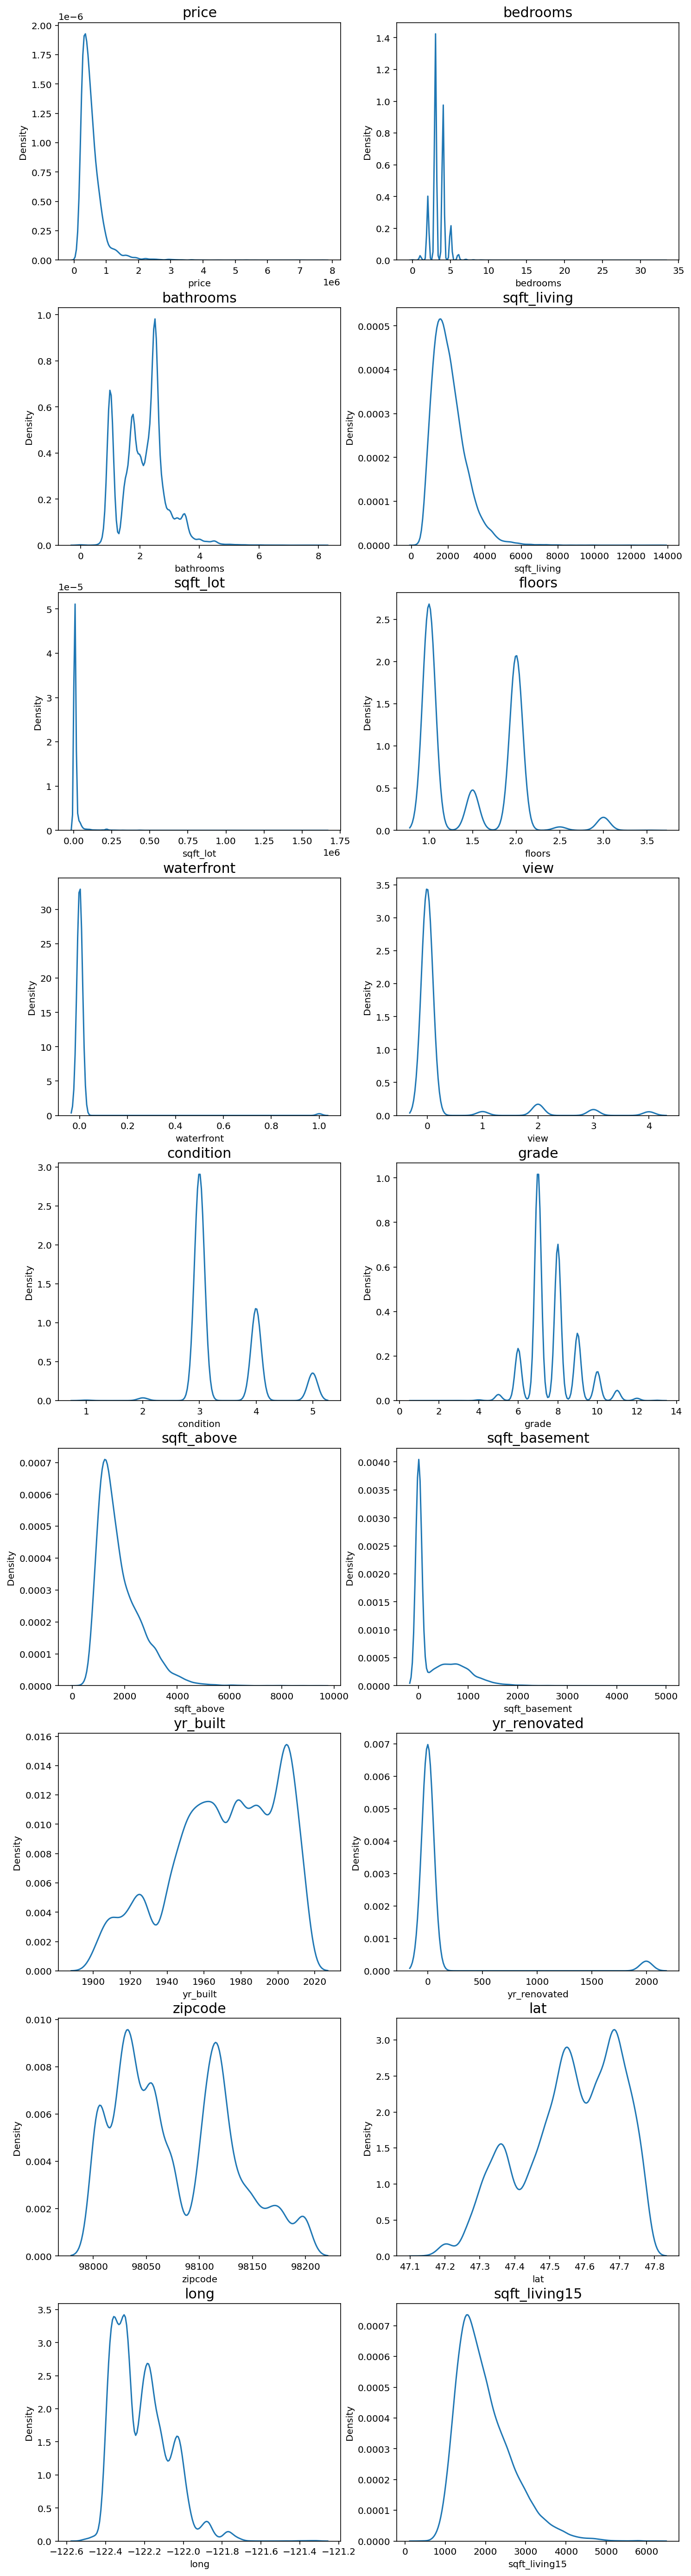

In [12]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50)) 

# id 변수(count==0인 경우)는 제외하고 분포를 확인
# kdeplot은 이산(discrete) 데이터의 경우에도 부드러운 곡선으로 전체 분포를 확인할 수 있도록 하는 시각화 함수
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [13]:
# 치우친 컬럼들을 skew_columns 리스트 안에 담고, 모두 np.log1p()를 활용해서 로그 변환
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('😆')

😆


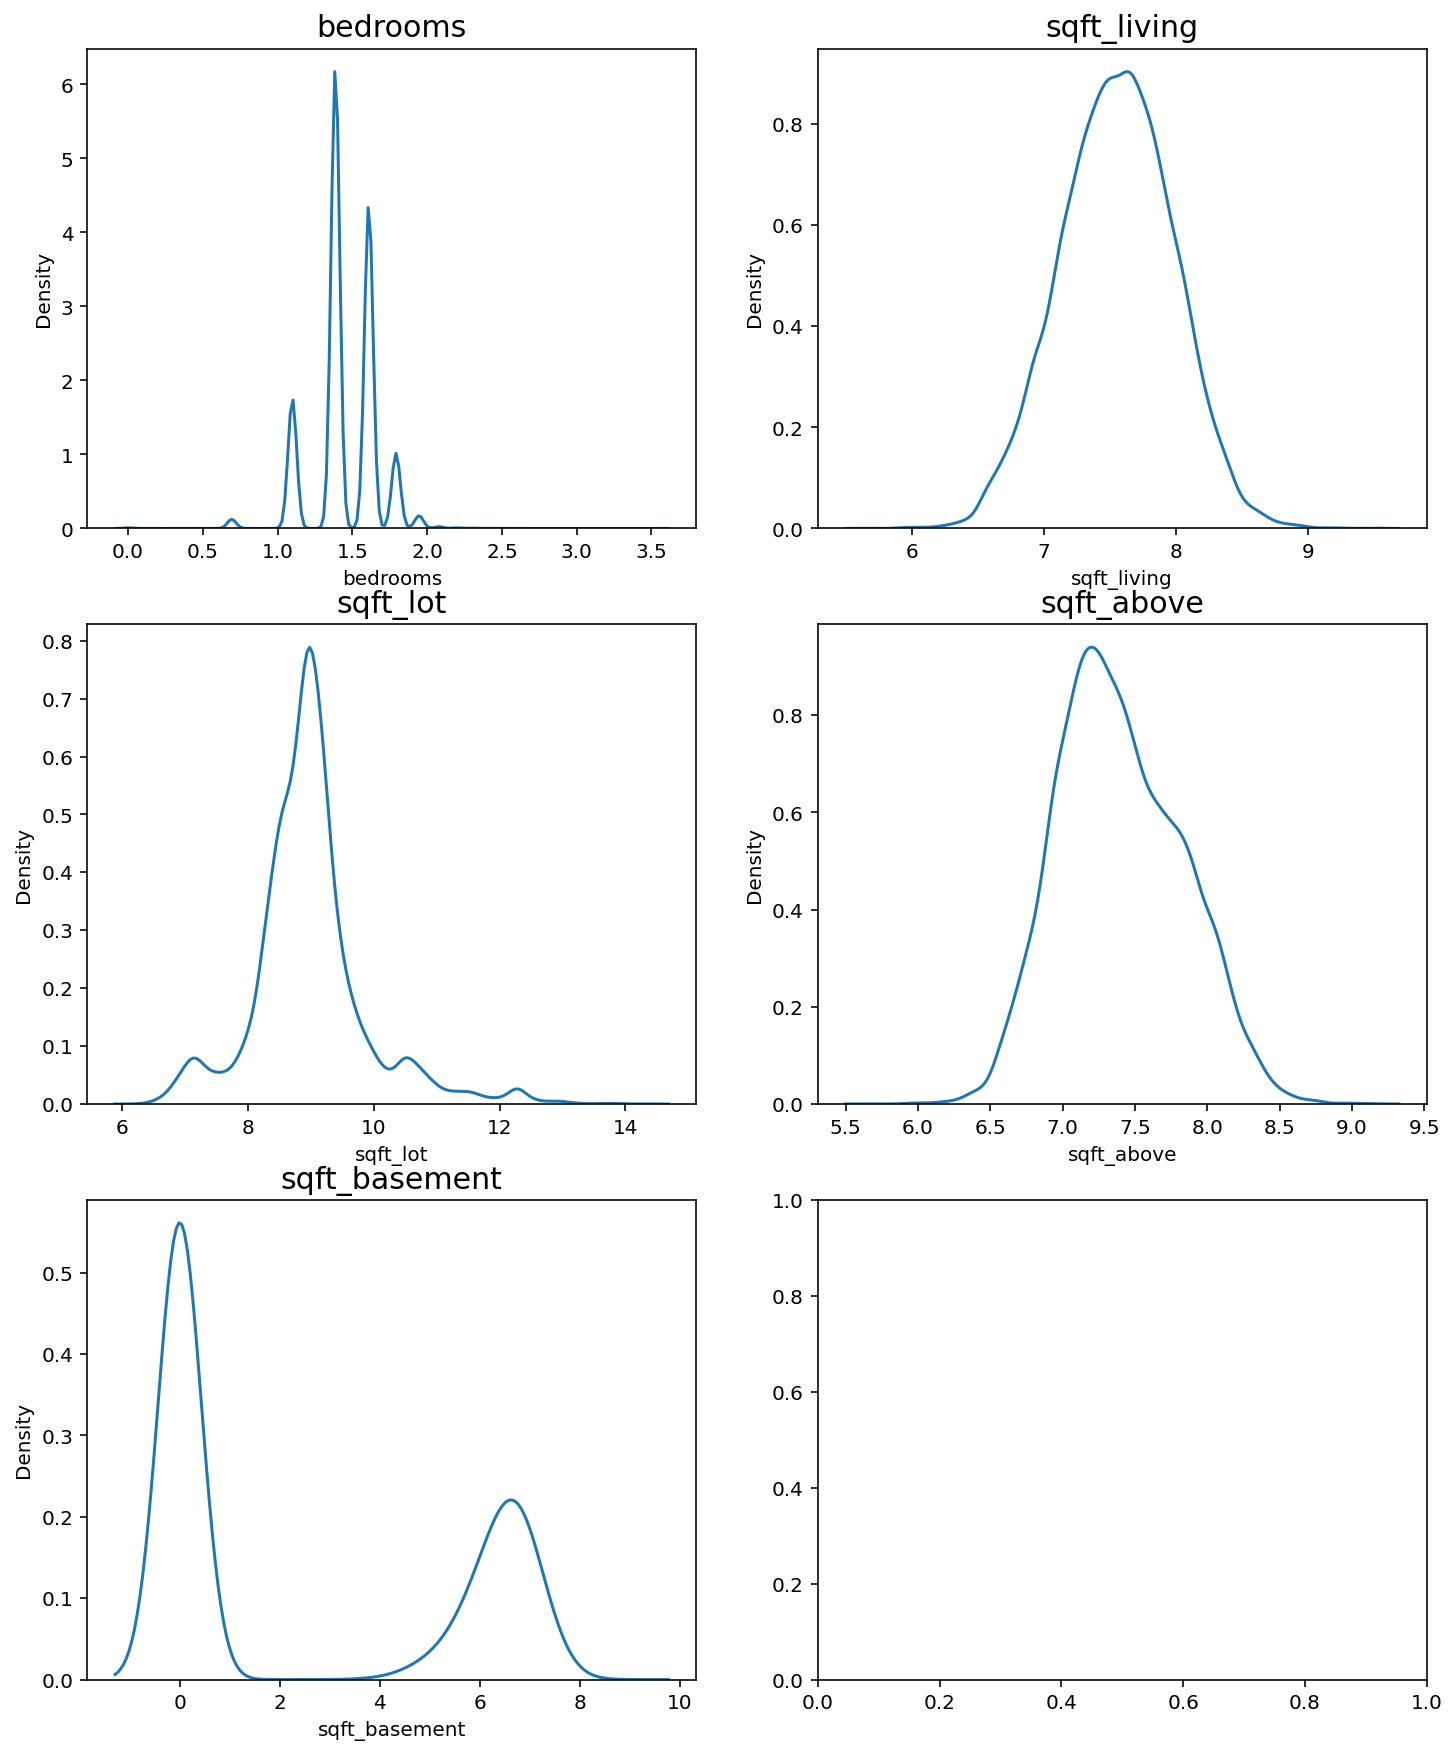

In [14]:
#로그 변환 후에 다시 분포 확인
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [11]:
#타겟데이터인 y보기
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

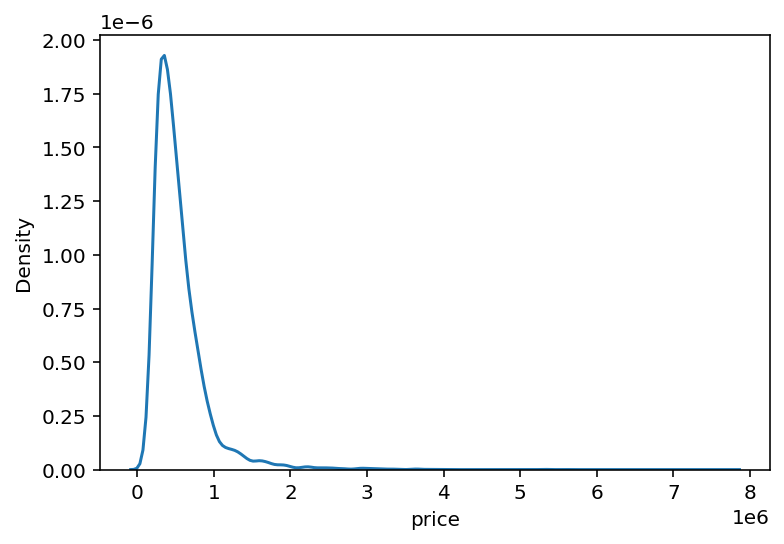

In [12]:
# seaborn의 `kdeplot`을 활용해 `y`의 분포를 확인
# 원래 price의 분포
sns.kdeplot(y)
plt.show()

In [13]:
# price는 왼쪽으로 크게 치우쳐 있는 형태
# 따라서 np.log1p() 함수를 통해 로그 변환
# 모델이 값을 예측한 후에 다시 np.exp1m()을 활용해서 되돌리겠음
#np.exp1m()은 np.log1p()과는 반대로 각 원소 x마다 exp(x)-1의 값을 반환
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

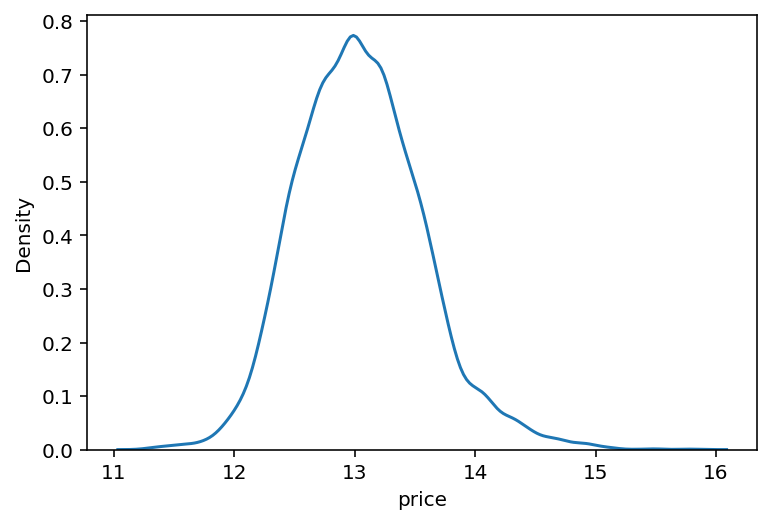

In [14]:
sns.kdeplot(y)
plt.show()

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [15]:
#  전체 데이터를 다시 나누어 줍니다.
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('😆')

😆


## 모델 설계     
* Baseline 커널에서는 여러 가지 모델을 함께 사용해서 결과를 섞는, 블렌딩(blending) 이라는 기법을 활용    
* 블렌딩이란 하나의 개별 모델을 사용하는 것이 아니라 다양한 여러 모델을 종합하여 결과를 얻는 기법

### ✓ Average Blending

In [16]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

얍💢


### ✓ Cross Validation

In [17]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                                  kf=kfold))
print('얍💢')

얍💢


## 다시 한번, 내 입맛대로 데이터 준비하기

## 모델 튜닝

### RMSE 계산

In [7]:
#데이터셋을 훈련 데이터셋과 검증 데이터셋으로 나누기 위한 train_test_split 함수와, RMSE 점수를 계산하기 위한 mean_squared_error를 가져오기
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

!주의할점!       

y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값이기 때문에 원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 함

In [17]:
# 점수를 매기는 것과 같은 평가 척도인 RMSE를 계산하기 위한 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [18]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


In [19]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값
#random_state=None    
random_state=2020    

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [20]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


## 함수로 튜닝하면서 학습하기

### GridSearch   
하이퍼 파라미터 튜닝의 최강자, 그리드 탐색

<GridSearchCV에 입력되는 인자>
* param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
* scoring : 모델의 성능을 평가할 지표
* cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
* verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
* n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    #GridSearchCV모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=verbose, n_jobs=n_jobs)

    #모델 fitting
    grid_model.fit(train, y)
    
    #결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    #데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    
    return results

In [23]:
#위에 만든그리드 함수로 간단한 그리드 탐색하기
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    1.9s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


가장 좋은 조합은 max_depth=10, n_estimators=100인것을 알 수 있음

* max_depth, n_estimators 값 바꾸고 score 구해보기

In [32]:
model = LGBMRegressor(max_depth=20, n_estimators=300, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([13.12160458, 13.10226918, 14.15043868, ..., 13.05037436,
       12.67158278, 13.01735592])

* 로그변환했던 것을 되돌려서 원래 스케일로 만들기

In [33]:
prediction = np.expm1(prediction)
prediction

array([ 499619.74521686,  490052.17258291, 1397838.90879818, ...,
        465269.55869982,  318564.30877008,  450157.90324192])

In [34]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [35]:
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [36]:
# price 데이터를 덮어주기
submission['price'] = prediction
submission.head()

,id,price
0,15035,4.996197e+05
1,15036,4.900522e+05
2,15037,1.397839e+06
3,15038,3.072446e+05
4,15039,3.279127e+05


In [37]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [38]:
#위에서 했던 과정을 간단하게 함수로 표현
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [39]:
#모델을 학습시킨 후 예측결과저장
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


<img width="860" alt="스크린샷 2021-08-09 오후 10 34 08" src="https://user-images.githubusercontent.com/63396019/128714970-829bde35-e803-4f5e-8a2b-b3ff48ca42d9.png">


## 스코어

* 첫 번째 스코어(맨 처음 그대로 스코어 점수 구해봤을 때)

<img width="936" alt="스크린샷 2021-07-29 오후 5 20 34" src="https://user-images.githubusercontent.com/63396019/128715136-dbe478cf-bf48-4135-a021-091651518bb7.png">

* 최종 스코어

<img width="860" alt="스크린샷 2021-08-09 오후 10 34 08" src="https://user-images.githubusercontent.com/63396019/128714970-829bde35-e803-4f5e-8a2b-b3ff48ca42d9.png">

## - 회고 -
#### 캐글을 처음 접해봤는데 솔직히 전체적인 흐름을 이해하고 진행하기 쉽지 않았다.
#### 지금은 baseline이 따로 있어서 따라갔지만 진짜 대회는 그렇지 않기때문에 만약에 캐글대회를 나가게 된다면 과연 내가 잘할 수 있을지 의문이 들정도로 아직까지 공부가 더 필요하다는 것을 느꼈다.
#### 그래도 어떻게 해야하는지 알 수 있고 곧 하게 될 인천캠퍼스 캐글대회를 준비하기 좋은 exploration이었던 것 같다.   
#### 그리고 LGBMRegressor, XGBRegressor, RandomForestRegressor 등 모델에대해서 이해가 좀 더 필요한 것 같고   
#### 상위권 달성한 커널은 스태킹 앙상블 같은 기법도 활용했다고 하는데 다른 사람들이 한 내용도 한번 공부해 볼 필요성을 느꼈다.